In [41]:
import time
import datetime
import numpy as np
import pickle
import sklearn.model_selection as skmod
import statsmodels.formula.api as smf
from statsmodels.nonparametric.smoothers_lowess import lowess
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
% matplotlib inline

## Predicting square meter prices with spatiotemporal nearest neighbor regression

In [2]:
sales = gpd.GeoDataFrame(pd.read_pickle('2014-01-01_2018-07-31_koebenhavn_predictive.pkl'), geometry='coords')
sales.crs = {'init': 'epsg:2077'}
nn_sales = pd.read_pickle('nn_frame_predictive.pkl').reset_index()

In [3]:
sales_train, sales_test = skmod.train_test_split(sales, test_size=0.2, random_state=1459)

In [4]:
def ws(df, weights, wdecay) :
    wdists = weights[0] * df['dist']
    wtimes = weights[1] * abs(df['time'])
    return  (1 / ((1 + wdists + wtimes) ** wdecay))

In [5]:
def nn_est(sales, nn_sales, predict=['price_m2'], 
           bordermatch=False, maxdist=500, maxtime=np.inf,
           weights=[], wdecay=None,
           forceest = []) :
    
    filtered = nn_sales.copy()
    
    if (maxdist<500) : 
        filtered = filtered[filtered['dist']<=maxdist]
    
    filtered = filtered[filtered['time']<=maxtime]
    
    if bordermatch : 
        filtered = filtered[filtered['bordermatch']]
        
    filtered['w'] = ws(filtered, weights, wdecay) if (len(weights)>0) else 1
    
    ests = filtered.groupby('s1').apply(lambda df : np.average(sales.loc[df['s2'], predict], 
                                                               weights = df['w'],
                                                               axis=0))
    
    ests = pd.DataFrame(dict([(predict[i], ests.apply(lambda a : a[i])) for i in range(0,len(predict))]))
    
    ests = ests.join(filtered[['s1','s2']].groupby('s1').count().rename(columns={'s2':'n_nns'}))
    
    if (len(forceest)>0) :
        missing = forceest[~forceest.isin(ests.index)]
        for i in missing :
            nns = nn_sales[nn_sales['s1']==i]
            nn = nns.loc[nns['dist'].idxmin(),'s2']
            for p in predict :
                ests.loc[i,p] = sales.loc[nn,p]
    
    return ests

In [6]:
def r2(ys, preds) : 
    sstot = np.sum((ys - np.mean(ys))**2)
    ssres = np.sum((ys - preds)**2)
    return 1 - (ssres/sstot)

In [7]:
def crossval(est, k=4) :
    kfoldidxs = np.array(np.array_split(sales_train.index, indices_or_sections=k))
    r2s = []
    for i in range(0,k) :
        testidx = kfoldidxs[i]
        trainidx = np.concatenate(np.delete(kfoldidxs, i, axis=0), axis=None)
        this_nn_sales = nn_sales[(nn_sales['s1'].isin(testidx)) & (nn_sales['s2'].isin(trainidx))]
        ps = est(this_nn_sales, pd.Series(testidx)).loc[:,'price_m2']
        r2s.append(r2(sales_train.loc[testidx,'price_m2'], ps))
    return np.mean(r2s)

In [8]:
# pars is a list of lists of maxdist, maxtime, wdist, wtime, and wdecay.
def gridSearchCV(pars, k=4) :
    r2s=[]
    ps=[]
    for par in itertools.product(*pars) :
        r = crossval(lambda df, testidx : nn_est(sales_train, df, maxdist=par[0], maxtime = par[1],
                                                 weights=[par[2],par[3]], wdecay=par[4],
                                                 forceest = testidx), k)
        r2s.append(r)
        ps.append(par)
        pickle.dump([par, r], open('CVgrid_%s.pkl'%str(par),'wb'))
        print(par)
        print(r)
        print(datetime.datetime.now())
        print('------------------------------------------------------')
    return pd.DataFrame({'r2':r2s, 'pars':ps})

In [12]:
cvres = gridSearchCV([[150,250,500],[365,2*365,4*365],[1],[1],[0.5,1,2]],k=4)

(150, 365, 1, 1, 0.5)
0.483927955649
2018-09-01 01:38:55.787203
------------------------------------------------------
(150, 365, 1, 1, 1)
0.504086120729
2018-09-01 01:40:01.099030
------------------------------------------------------
(150, 365, 1, 1, 2)
0.478103132832
2018-09-01 01:41:15.369508
------------------------------------------------------
(150, 730, 1, 1, 0.5)
0.487995259388
2018-09-01 01:42:25.883717
------------------------------------------------------
(150, 730, 1, 1, 1)
0.508930688059
2018-09-01 01:43:30.495326
------------------------------------------------------
(150, 730, 1, 1, 2)
0.483601718758
2018-09-01 01:44:51.325054
------------------------------------------------------
(150, 1460, 1, 1, 0.5)
0.465625734736
2018-09-01 01:46:06.430741
------------------------------------------------------
(150, 1460, 1, 1, 1)
0.501973062482
2018-09-01 01:47:24.772855
------------------------------------------------------
(150, 1460, 1, 1, 2)
0.484979682138
2018-09-01 01:48:36.

In [13]:
pickle.dump(cvres, open('cvres.pkl','wb'))

In [14]:
# And the winner is: 
cvres.loc[cvres['r2'].idxmax(),]

pars    (150, 730, 1, 1, 1)
r2                 0.508931
Name: 4, dtype: object

In [15]:
cvres150 = cvres[(cvres['pars'].apply(lambda p : p[0]==150))]

In [16]:
cvres250 = cvres[(cvres['pars'].apply(lambda p : p[0]==250))]

In [17]:
cvres500 = cvres[(cvres['pars'].apply(lambda p : p[0]==500))]

In [20]:
cvres250.loc[cvres250['r2'].idxmax(),]

pars    (250, 730, 1, 1, 1)
r2                 0.505009
Name: 13, dtype: object

In [19]:
cvres500.loc[cvres500['r2'].idxmax(),]

pars    (500, 730, 1, 1, 2)
r2                 0.502614
Name: 23, dtype: object

In [21]:
nn_sales_testtrainred = nn_sales[(nn_sales['s1'].isin(sales_test.index)) & (nn_sales['s2'].isin(sales_train.index))]

In [22]:
ps = nn_est(sales, nn_sales_testtrainred, maxdist=150, maxtime=730, weights=[1,1],wdecay=1,forceest=sales_test.index)

In [23]:
r2(sales_test['price_m2'], ps['price_m2'])

0.5247581913999401

## Predicting square meter prices with linear regression models

In [35]:
pmod_spatiotemp = smf.ols('price_m2 ~ yearseason + city', data=sales_train).fit()
r2(sales_test['price_m2'], pmod_spatiotemp.predict(sales_test))

0.31906597481152155

In [36]:
pmod_houseinfo = smf.ols('price_m2 ~ yearseason + city + type + res_area', data=sales_train).fit()
r2(sales_test['price_m2'], pmod_houseinfo.predict(sales_test))

0.3504961595546766

In [37]:
pmod_houseinfo_socioeco = smf.ols('price_m2 ~ yearseason + city + type + res_area + pct_ikke_vestlig + pct_lav_indkomst', data=sales_train).fit()
r2(sales_test['price_m2'], pmod_houseinfo_socioeco.predict(sales_test))

0.38577370589390636

## Causal analysis with spatiotemporal matching

In [26]:
sales = gpd.GeoDataFrame(pd.read_pickle('2014-01-01_2018-07-31_koebenhavn_causal.pkl'), geometry='coords')
sales.crs = {'init': 'epsg:2077'}
nn_sales = pd.read_pickle('nn_frame_causal.pkl').reset_index()

In [27]:
sales['treatment_ord'] = pd.cut(sales['treatment'], [-3,-2,-1,0,1,2,3])

In [30]:
cfss = [nn_est(sales, nn_sales, predict=['price_m2', 
                                                       'res_area', 
                                                       'sale_day', 
                                                       'pct_lav_indkomst', 
                                                       'pct_ikke_vestlig'], maxdist=d, maxtime=2*365, bordermatch=True) for d in [150,250,500]]

In [31]:
pickle.dump(cfss, open('cffs.pkl', 'wb'))

In [32]:
cfss = pickle.load(open('cffs.pkl','rb'))

In [38]:
def make_sales_cf(cf_df, sales, maxdist) :
    cols = cf_df.columns
    newcols = ['cf_' + c for c in cols]
    cf_df = cf_df.rename(columns=dict(zip(cols,newcols))).rename(columns={'cf_n_nns' : 'n_nns'})
    sales_cf = sales.join(cf_df, how='inner')
    for c in cols :
        if (c!='n_nns') :
            sales_cf['te_' + c] = sales_cf[c] - sales_cf['cf_' + c]
            sales_cf['norm_te_' + c] = (sales_cf['te_' + c] - sales_cf['te_' + c].mean()) / sales_cf['te_' + c].std()
            sales_cf['sm_te_' + c] = lowess(sales_cf['norm_te_' + c], sales_cf['treatment'], return_sorted=False)
    sales_cf['maxdist'] = maxdist
    return sales_cf

In [42]:
sales_cfs = [make_sales_cf(z[0], sales, z[1]) for z in zip(cfss, [150,250,500])]

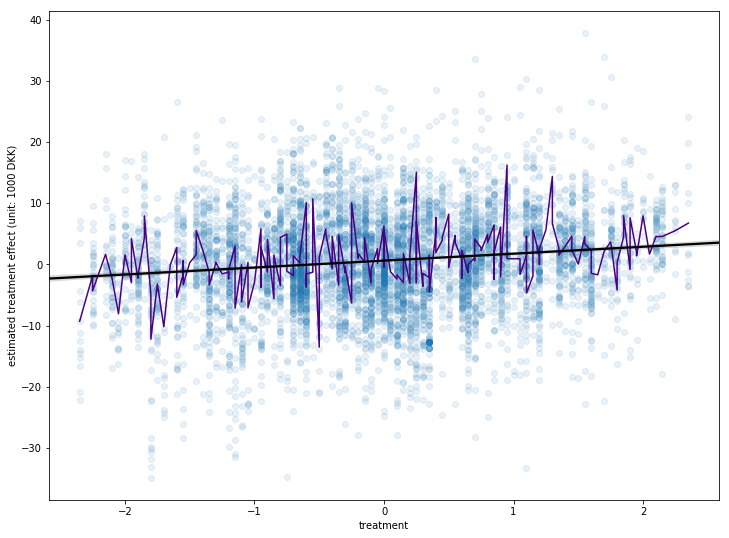

In [78]:
fig, base_plt = plt.subplots(1,1,figsize=(12,9))
sns.regplot('treatment', 'te_price_m2', data=sales_cfs[0], fit_reg=False, scatter_kws={'alpha':0.1}, ax=base_plt)
sns.lineplot('treatment', 'te_price_m2', data=sales_cfs[0], ci=None, color='indigo', ax=base_plt)
sns.regplot('treatment', 'te_price_m2', data=sales_cfs[0], scatter=False, color='black', ax=base_plt)
base_plt.set_ylabel('estimated treatment effect (unit: 1000 DKK)')
fig.savefig('figs/treatment_effect_plt.png')

In [76]:
print(smf.ols('te_price_m2 ~ treatment + 0', data=sales_cfs[0]).fit().summary())

                            OLS Regression Results                            
Dep. Variable:            te_price_m2   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     130.0
Date:                Sat, 01 Sep 2018   Prob (F-statistic):           7.65e-30
Time:                        04:31:05   Log-Likelihood:                -23663.
No. Observations:                6778   AIC:                         4.733e+04
Df Residuals:                    6777   BIC:                         4.733e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
treatment      1.1104      0.097     11.402      0.0

In [77]:
print(smf.ols('price_m2 ~ skole_karsnit + yearseason + city + type + res_area + pct_ikke_vestlig + pct_lav_indkomst', data=sales).fit().summary())

                            OLS Regression Results                            
Dep. Variable:               price_m2   R-squared:                       0.482
Model:                            OLS   Adj. R-squared:                  0.481
Method:                 Least Squares   F-statistic:                     851.7
Date:                Sat, 01 Sep 2018   Prob (F-statistic):               0.00
Time:                        04:32:53   Log-Likelihood:                -85143.
No. Observations:               25689   AIC:                         1.703e+05
Df Residuals:                   25660   BIC:                         1.706e+05
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               19.4851 